# ライブラリのインストール

In [1]:
# !conda create -n my_env python=3.9
# !conda activate my_env
# 依存性の競合が少ない順でインストール
!pip install numpy==1.23.5
!pip install pandas
!pip install dowhy
!pip install econml shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Succe

In [2]:
# 乱数のシードを固定
import random
import numpy as np

random.seed(4963)
np.random.seed(4963)

In [3]:
# 使用するパッケージ（ライブラリと関数）を定義
import pandas as pd

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# 標準正規分布の生成用
from numpy.random import randn

# 因果グラフ用
import dowhy
from dowhy import CausalModel

# グラフの描画用
import matplotlib.pyplot as plt
%matplotlib inline

# 回帰分析用
import statsmodels.api as sm

# グラフ描画用
import seaborn as sns
import matplotlib.pyplot as plt

# ダミー変数作成用
from sklearn.preprocessing import OneHotEncoder

# 計算資源を測定
import resource

import os
import time
import pickle
from sklearn.model_selection import train_test_split # 学習データと検証データに分ける関数
from sklearn import metrics # 精度検証に必要な関数
from sklearn.linear_model import LogisticRegression # ロジスティック回帰に必要な関数
from sklearn.preprocessing import StandardScaler # 係数解釈をしやすくするため標準化を行う。標準化のための関数

# ロジスティック回帰
import statsmodels.api as sm
from scipy.special import expit  # シグモイド関数（ロジスティック）

# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# LightGBMモデルを作成
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# 評価指標
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# VIFの計算
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# データの読み込み

In [4]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [115]:
# pickleファイルの読み込み
df = pd.read_pickle('drive/MyDrive/Colab Notebooks/修士論文関係/df_sample1_processed.pickle')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,E1_1_C,E1_1_D,E1_1_E,E1_1_F,E1_1_G,E1_1_H,E1_1_I,E1_1_J,E1_1_K,E1_1_L
0,11932,00654615,310,20230801,10,2023-08-01,2,4,87,2023,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,02019,00733795,310,20240301,10,2024-03-01,2,F,15514,2024,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,06928,00818002,310,20230401,10,2023-04-01,2,F,7848,2023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01661,00602504,310,20230601,10,2023-06-01,2,4,15587,2023,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,06858,00797063,310,20230801,10,2023-08-01,2,4,7996,2023,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [116]:
# このやり方だと、B7_1への介入の操作となり、交絡関係が切れてしまう

# ベースライン確率 (B7_1=0 のときの A8_1_adjusted=1 の確率)
# baseline_prob = 0.39
# df['baseline_prob'] = baseline_prob

# 目標とする ATE
# target_ate = 0.05

# 介入群の目標確率
# treatment_prob = baseline_prob + target_ate

# 確率が0-1の範囲に収まるように調整
# treatment_prob = np.clip(treatment_prob, 0, 1)

# A8_1_adjusted の生成
# def generate_a8_1(row):
#     if row['B7_1'] == 0:
#         return np.random.binomial(1, row['baseline_prob'])
#     else:
#         return np.random.binomial(1, treatment_prob)

# df['A8_1_adjusted'] = df.apply(generate_a8_1, axis=1)

# 生成されたデータのATEを確認
# actual_ate = df.groupby('B7_1')['A8_1_adjusted'].mean().diff().iloc[-1]
# print(f"目標ATE: {target_ate}")
# print(f"生成されたデータのATE: {actual_ate}")

# クロス集計で確認
# print(pd.crosstab(df['B7_1'], df['A8_1_adjusted'], normalize='index'))



# モデルの設定

In [ ]:
dowhy.__version__

'0.12'

In [ ]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [ ]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['G4', 'E1', 'I3', 'H5', 'H1', 'H7', 'E6', 'Z6', 'F1', 'E2', 'G9', 'Z14', 'B7_1',
         'A11', 'C3', 'A8_1_adjusted']
edges = [
    ('G4', 'I3'),
    ('I3', 'H5'),
    ('I3', 'B7_1'),
    ('I3', 'A8_1_adjusted'),
    ('E1', 'I3'),
    ('E1', 'H5'),
    ('E1', 'B7_1'),
    ('H5', 'H1'),
    ('H5', 'H7'),
    ('H5', 'B7_1'),
    ('H5', 'A8_1_adjusted'),
    ('H7', 'B7_1'),
    ('H7', 'A8_1_adjusted'),
    ('H1', 'Z14'),
    ('H1', 'B7_1'),
    ('H1', 'A8_1_adjusted'),
    ('E1', 'Z14'),
    ('E2', 'B7_1'),
    ('E2', 'A8_1_adjusted'),
    ('Z6', 'B7_1'),
    ('Z6', 'A8_1_adjusted'),
    ('G9', 'B7_1'),
    ('G9', 'A8_1_adjusted'),
    ('F1', 'B7_1'),
    ('F1', 'A8_1_adjusted'),
    ('Z14', 'B7_1'),
    ('Z14', 'A8_1_adjusted'),
    ('B7_1', 'C3'),
    ('B7_1', 'A8_1_adjusted'),
    ('C3', 'A8_1_adjusted'),
    ('E1', 'A8_1_adjusted'),
    ('Z14', 'A11'),
    ('A11', 'A8_1_adjusted')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [ ]:
# Instantiate the CausalModel
model = CausalModel(
    data=df,
    treatment='B7_1',
    outcome='A8_1_adjusted',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

/usr/local/lib/python3.11/dist-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


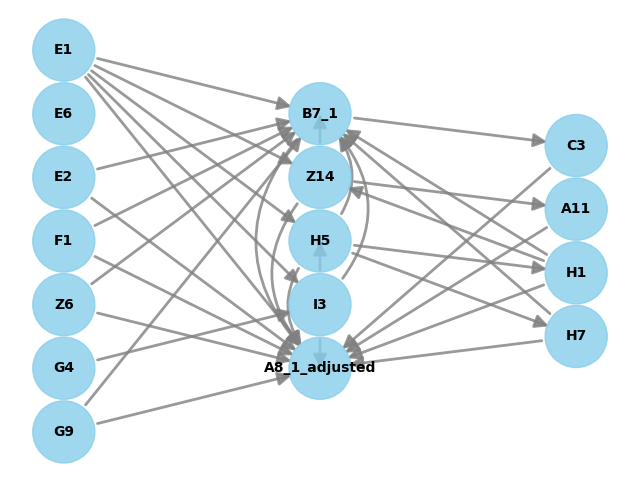

In [ ]:
model.view_model()

In [ ]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                     
───────(E[A_8_1_adjusted|H7,G9,I3,H5,Z6,H1,F1,Z14,E2,E1])
d[B₇ ₁]                                                  
Estimand assumption 1, Unconfoundedness: If U→{B7_1} and U→A8_1_adjusted then P(A8_1_adjusted|B7_1,H7,G9,I3,H5,Z6,H1,F1,Z14,E2,E1,U) = P(A8_1_adjusted|B7_1,H7,G9,I3,H5,Z6,H1,F1,Z14,E2,E1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
adjustment_set = ['E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']

因果グラフから、上記の７つを変数に指定する

# 順序尺度は連続変数、名義尺度はダミー変数に置換した場合

In [117]:
# 説明変数の選択
X = df[['B7_1']]  # 説明変数

# 名義尺度をダミー変数に変更
# 説明変数とする列のリスト
categorical_cols = ['B7_1']
_X = df[categorical_cols].copy() # 元のDataFrameを直接変更しないようにコピー
# OneHotEncoderを初期化
encoder = OneHotEncoder(sparse_output=False, drop='first')
# 指定した列をOne-Hotエンコーディング
encoded_cols = encoder.fit_transform(_X[categorical_cols])
# エンコードされた列の名前を取得
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
# エンコードされたデータを新しいデータフレームに変換
encoded_df = pd.DataFrame(encoded_cols, index=_X.index, columns=encoded_feature_names)
# 元のデータフレームからカテゴリカルな列を削除し、エンコードされたデータフレームと結合
X_processed = pd.concat([_X.drop(columns=categorical_cols), encoded_df], axis=1)

df = pd.concat([df, X_processed], axis=1)

In [118]:
def train_model(X, Y, model):
    '''モデルの学習と学習時間の計測

    Args:
            X(DataFrame): 説明変数
            Y(np.ndarray): 目的変数
            model:学習させるモデル

    Returns:
            model: 学習済みのモデル
            elapsed_time:学習時間(単位:秒)
    '''
    # 学習、学習時間を計測
    start = time.time()
    model = model.fit(X, Y)
    elapsed_time = time.time() - start

    # 学習時間の表示
    print('学習時間(単位：秒): \n', elapsed_time)

    return model, elapsed_time

In [119]:
X = df[['E2_1', 'E2_2', 'F1_1', 'I3_1', 'I3_2', 'I3_3', 'I3_4', 'I3_5', 'I3_6',
       'I3_7', 'I3_8', 'I3_9', 'G9_0', 'G9_1', 'E1_1_B', 'E1_1_C', 'E1_1_D',
       'E1_1_E', 'E1_1_F', 'E1_1_G', 'E1_1_H', 'E1_1_I', 'E1_1_J', 'E1_1_K',
       'E1_1_L', 'Z6', 'Z14', 'B7_1_1']]

In [120]:
# 欠損値の補完
X.fillna(0, inplace=True)

<ipython-input-120-8ea157108dc1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [121]:
start_cpu = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 開始時のCPU時間
# X = sm.add_constant(X['B7_1_1'])  # 定数項を追加
X = sm.add_constant(X)  # 定数項を追加
Y = df['A8_1_adjusted']  # 目的変数
Y = pd.to_numeric(df['A8_1_adjusted'], errors='coerce')

model = sm.Logit(Y, X).fit()  # モデルの適合

end_cpu = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 終了時のCPU時間
elapsed_cpu = end_cpu - start_cpu  # 経過CPU時間

print(model.summary())  # 結果の表示

max_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss  # 最大メモリ使用量
print(f"reg のCPU時間: {elapsed_cpu:.4f} 秒, 最大メモリ使用量: {max_memory} KB")
print(model.summary())  # 結果の表示

Optimization terminated successfully.
         Current function value: 0.668624
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          A8_1_adjusted   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299971
Method:                           MLE   Df Model:                           28
Date:                Thu, 17 Apr 2025   Pseudo R-squ.:               8.590e-05
Time:                        06:25:08   Log-Likelihood:            -2.0059e+05
converged:                       True   LL-Null:                   -2.0060e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1860
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5501      0.192     -2.872      0.004      -0.926      -0.175
E2_1           0.0155      0.

# VIFの計算

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# VIFを計算
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

   feature          VIF
0    const  2360.101009
1     E2_1     3.419320
2     E2_2     3.419733
3     F1_1     1.018175
4     I3_1     1.957987
5     I3_2     2.705395
6     I3_3     2.715725
7     I3_4     2.723479
8     I3_5     4.031642
9     I3_6     2.710634
10    I3_7     2.733623
11    I3_8     2.711229
12    I3_9     2.718812
13    G9_0     1.896633
14    G9_1     1.911719
15  E1_1_B     8.415836
16  E1_1_C    43.309121
17  E1_1_D   148.276943
18  E1_1_E   146.459654
19  E1_1_F   195.650379
20  E1_1_G   237.085688
21  E1_1_H   260.228600
22  E1_1_I   260.656983
23  E1_1_J   236.009087
24  E1_1_K   196.452680
25  E1_1_L   306.302282
26      Z6     1.000282
27     Z14     1.000100
28  B7_1_1     1.095537


In [28]:
X.columns

Index(['const', 'E2_1', 'E2_2', 'F1_1', 'I3_1', 'I3_2', 'I3_3', 'I3_4', 'I3_5',
       'I3_6', 'I3_7', 'I3_8', 'I3_9', 'G9_0', 'G9_1', 'E1_1_B', 'E1_1_C',
       'E1_1_D', 'E1_1_E', 'E1_1_F', 'E1_1_G', 'E1_1_H', 'E1_1_I', 'E1_1_J',
       'E1_1_K', 'E1_1_L', 'Z6', 'Z14', 'B7_1_1'],
      dtype='object')

In [37]:
df_x = X[['F1_1','Z6', 'Z14', 'B7_1_1']]

In [38]:
# 相関係数行列を計算
correlation_matrix = df_x.corr()

# 結果を表示
print(correlation_matrix)

            F1_1        Z6       Z14    B7_1_1
F1_1    1.000000  0.000360 -0.000959  0.026090
Z6      0.000360  1.000000  0.001248  0.056041
Z14    -0.000959  0.001248  1.000000  0.016591
B7_1_1  0.026090  0.056041  0.016591  1.000000


In [14]:
correlation_with_A = df.corr()['A']
print("\n変数 'A' との相関:\n", correlation_with_A)

,count
I3,
5,60287
4,30131
9,30095
7,30052
3,29970
6,29895
2,29870
8,29704
1,15144


In [122]:
_df = pd.concat([X, Y], axis=1)
_df = _df.drop('const', axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116955, number of negative: 183045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389850 -> initscore=-0.447943
[LightGBM] [Info] Start training from score -0.447943
reg のCPU時間: 2.9339 秒, 最大メモリ使用量: 3490364 KB
ATE： 0.07860666666666667


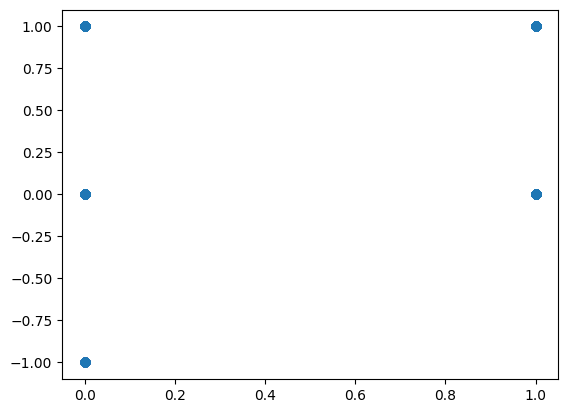

In [123]:
import resource

# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# LightGBMモデルを作成
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# _df.replace('', np.nan, inplace=True)
# cols_to_convert = ['E1', 'G4', 'I3', 'H5', 'H1', 'H7', 'F1', 'E2', 'G9', 'B7_1', 'C3', 'A11']
# for col in cols_to_convert:
#     _df[col] = pd.to_numeric(_df[col], errors='coerce')
# _df['A8_1_adjusted'] = _df['A8_1_adjusted'].astype(int)

# モデルを学習
start_cpu = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 開始時のCPU時間
# reg = RandomForestRegressor(max_depth=4)
clf = LGBMClassifier(objective='binary',  # 二値分類の場合
                     metric='binary_logloss', # 評価指標
                     random_state=42)
# reg = LGBMRegressor(objective='regression', metric='rmse', random_state=42) # 回帰問題の場合

X = _df.loc[:, ['E2_1', 'E2_2', 'F1_1', 'I3_1', 'I3_2', 'I3_3', 'I3_4', 'I3_5', 'I3_6',
       'I3_7', 'I3_8', 'I3_9', 'G9_0', 'G9_1', 'E1_1_B', 'E1_1_C', 'E1_1_D',
       'E1_1_E', 'E1_1_F', 'E1_1_G', 'E1_1_H', 'E1_1_I', 'E1_1_J', 'E1_1_K',
       'E1_1_L', 'Z6', 'Z14', 'B7_1_1']] # 'E1_P', 'E1_Q', 'E1_R'

clf.fit(X, _df[['A8_1_adjusted']])

end_cpu = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 終了時のCPU時間
elapsed_cpu = end_cpu - start_cpu  # 経過CPU時間
max_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss  # 最大メモリ使用量
print(f"reg のCPU時間: {elapsed_cpu:.4f} 秒, 最大メモリ使用量: {max_memory} KB")

# 処置が0と1の状態を作成する
X_0 = X.copy()
X_0['B7_1_1'] = 0.0

X_1 = X.copy()
X_1['B7_1_1'] = 1.0

# ATEの計算
ATE = (clf.predict(X_1)-clf.predict(X_0)).mean()
print("ATE：", ATE)

# 推定された治療効果を各人ごとに求めます
t_estimated = clf.predict(X_1)-clf.predict(X_0)
plt.scatter(_df[['B7_1_1']], t_estimated,
            label="estimated_treatment-effect")

# 正解を描画
# plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

In [124]:
# ブートストラップ法による信頼区間の計算
n_bootstrap = 20  # ブートストラップ標本数
ate_bootstrap = []
for _ in range(n_bootstrap):
    df_bootstrap = _df.sample(frac=1, replace=True)  # 復元抽出
    X_bootstrap = df_bootstrap.loc[:, ['E2_1', 'E2_2', 'F1_1', 'I3_1', 'I3_2', 'I3_3', 'I3_4', 'I3_5', 'I3_6',
       'I3_7', 'I3_8', 'I3_9', 'G9_0', 'G9_1', 'E1_1_B', 'E1_1_C', 'E1_1_D',
       'E1_1_E', 'E1_1_F', 'E1_1_G', 'E1_1_H', 'E1_1_I', 'E1_1_J', 'E1_1_K',
       'E1_1_L', 'Z6', 'Z14', 'B7_1_1']]
    clf_bootstrap = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
    clf_bootstrap.fit(X_bootstrap, df_bootstrap[['A8_1_adjusted']])

    X_0_bootstrap = X_bootstrap.copy()
    X_0_bootstrap['B7_1_1'] = 0.0
    X_1_bootstrap = X_bootstrap.copy()
    X_1_bootstrap['B7_1_1'] = 1.0
    ate_bootstrap.append((clf_bootstrap.predict(X_1_bootstrap) - clf_bootstrap.predict(X_0_bootstrap)).mean())

# 信頼区間の計算
ate_bootstrap = np.array(ate_bootstrap)
confidence_interval = np.percentile(ate_bootstrap, [2.5, 97.5])
print("ATEの95%信頼区間：", confidence_interval)

# 信頼区間に0が含まれているかどうかで有意性を判断
if confidence_interval[0] <= 0 <= confidence_interval[1]:
    print("ATEは統計的に有意ではありません。")
else:
    print("ATEは統計的に有意です。")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117330, number of negative: 182670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391100 -> initscore=-0.442691
[LightGBM] [Info] Start training from score -0.442691


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116574, number of negative: 183426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388580 -> initscore=-0.453285
[LightGBM] [Info] Start training from score -0.453285


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116913, number of negative: 183087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389710 -> initscore=-0.448531
[LightGBM] [Info] Start training from score -0.448531


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117014, number of negative: 182986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390047 -> initscore=-0.447116
[LightGBM] [Info] Start training from score -0.447116


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117294, number of negative: 182706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390980 -> initscore=-0.443195
[LightGBM] [Info] Start training from score -0.443195


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117411, number of negative: 182589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391370 -> initscore=-0.441557
[LightGBM] [Info] Start training from score -0.441557


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117163, number of negative: 182837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390543 -> initscore=-0.445029
[LightGBM] [Info] Start training from score -0.445029


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116879, number of negative: 183121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389597 -> initscore=-0.449008
[LightGBM] [Info] Start training from score -0.449008


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116703, number of negative: 183297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389010 -> initscore=-0.451476
[LightGBM] [Info] Start training from score -0.451476


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117250, number of negative: 182750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390833 -> initscore=-0.443811
[LightGBM] [Info] Start training from score -0.443811


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116918, number of negative: 183082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389727 -> initscore=-0.448461
[LightGBM] [Info] Start training from score -0.448461


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116811, number of negative: 183189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389370 -> initscore=-0.449961
[LightGBM] [Info] Start training from score -0.449961


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117029, number of negative: 182971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390097 -> initscore=-0.446906
[LightGBM] [Info] Start training from score -0.446906


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117212, number of negative: 182788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390707 -> initscore=-0.444343
[LightGBM] [Info] Start training from score -0.444343


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117156, number of negative: 182844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390520 -> initscore=-0.445127
[LightGBM] [Info] Start training from score -0.445127


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117096, number of negative: 182904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390320 -> initscore=-0.445967
[LightGBM] [Info] Start training from score -0.445967


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117218, number of negative: 182782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390727 -> initscore=-0.444259
[LightGBM] [Info] Start training from score -0.444259


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 117035, number of negative: 182965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390117 -> initscore=-0.446822
[LightGBM] [Info] Start training from score -0.446822


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116954, number of negative: 183046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389847 -> initscore=-0.447957
[LightGBM] [Info] Start training from score -0.447957


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 116632, number of negative: 183368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388773 -> initscore=-0.452471
[LightGBM] [Info] Start training from score -0.452471
ATEの95%信頼区間： [-0.0008255  0.2306795]
ATEは統計的に有意ではありません。


In [125]:
# 評価指標の算出と表示
print("Accuracy:", accuracy_score(_df['A8_1_adjusted'], clf.predict(X)))
print("Precision:", precision_score(_df['A8_1_adjusted'], clf.predict(X)))
print("Recall:", recall_score(_df['A8_1_adjusted'], clf.predict(X)))
print("F1 Score:", f1_score(_df['A8_1_adjusted'], clf.predict(X)))

Accuracy: 0.6107466666666667
Precision: 0.7209876543209877
Recall: 0.0024966867598649055
F1 Score: 0.004976141785957737


In [126]:
df_0.columns

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'B7', 'B8', 'B9', 'C1', 'C3', 'E1', 'E2', 'E3', 'E4', 'F1', 'G4', 'G5',
       'G6', 'G7', 'G8', 'G9', 'H1', 'H5', 'H6', 'H7', 'I3', 'Z6', 'Z14',
       'A8_1', 'B7_1', 'E1_1', 'A8_1_adjusted', 'E2_1', 'E2_2', 'F1_1', 'I3_1',
       'I3_2', 'I3_3', 'I3_4', 'I3_5', 'I3_6', 'I3_7', 'I3_8', 'I3_9', 'G9_0',
       'G9_1', 'E1_1_B', 'E1_1_C', 'E1_1_D', 'E1_1_E', 'E1_1_F', 'E1_1_G',
       'E1_1_H', 'E1_1_I', 'E1_1_J', 'E1_1_K', 'E1_1_L', 'B7_1_1', 'year',
       'month'],
      dtype='object')

<ipython-input-127-0cec35bf98b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datetime_cols['year'] = pd.to_datetime(datetime_cols['E3']).dt.year
<ipython-input-127-0cec35bf98b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datetime_cols['month'] = pd.to_datetime(datetime_cols['E3']).dt.month
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116340, number of negative: 182160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 298500, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389749 -> initscore=-0.448368
[LightGBM] [Info] Start training from score -0.448368
clf_0 のCPU時間: 2.9430 秒, 最大メモリ使用量: 3720568 KB
[LightGBM] [Info] Number of positive: 615, number of negative: 885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


ATE： 0.24089
ATT： 0.38077333333333335


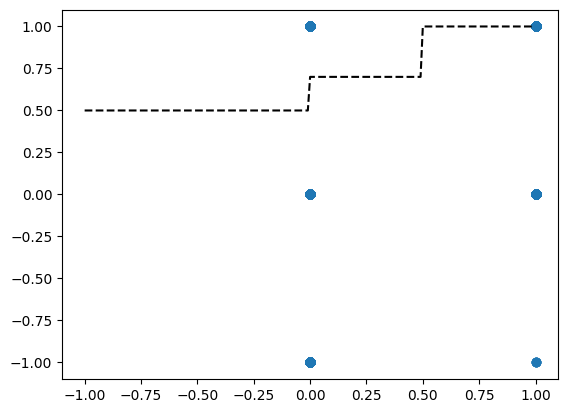

In [127]:
_df = df.copy()

# 日付型を連続変数に変換
datetime_cols = _df[['E3']]
datetime_cols['year'] = pd.to_datetime(datetime_cols['E3']).dt.year
datetime_cols['month'] = pd.to_datetime(datetime_cols['E3']).dt.month

_df = pd.concat([_df, datetime_cols[['year', 'month']]], axis=1)

categorical_cols = ['B7_1', 'E1', 'E2', 'F1', 'I3', 'G9']
for col in categorical_cols:
    _df[col] = _df[col].astype('category')

_df['A8_1_adjusted'] = _df['A8_1_adjusted'].astype(int)

# 集団を2つに分ける
df_0 = _df[_df.B7_1 == 0]  # 介入を受けていない集団
df_1 = _df[_df.B7_1 == 1]  # 介入を受けた集団

#df_0.fillna(0, inplace=True)
#df_1.fillna(0, inplace=True)

import resource

# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# LightGBMモデルを作成

X_0 = df_0.loc[:, ['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']]
X_1 = df_1.loc[:, ['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']]

# 介入を受けていないモデル
start_cpu_0 = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 開始時のCPU時間
# reg_0 = RandomForestRegressor(max_depth=3)
# reg_0 = LGBMRegressor(objective='regression', metric='rmse', random_state=42, categorical_feature=['category']) # 回帰問題の場合
clf_0 = LGBMClassifier(objective='binary',  # 二値分類の場合
                     metric='binary_logloss', # 評価指標
                     random_state=42)
clf_0.fit(X_0, df_0[['A8_1_adjusted']])
end_cpu_0 = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 終了時のCPU時間
elapsed_cpu_0 = end_cpu_0 - start_cpu_0  # 経過CPU時間
max_memory_0 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss  # 最大メモリ使用量
print(f"clf_0 のCPU時間: {elapsed_cpu_0:.4f} 秒, 最大メモリ使用量: {max_memory_0} KB")

# 介入を受けたモデル
start_cpu_1 = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 開始時のCPU時間
# reg_1 = RandomForestRegressor(max_depth=3)
# reg_1 = LGBMRegressor(objective='regression', metric='rmse', random_state=42, categorical_feature=['category']) # 回帰問題の場合
clf_1 = LGBMClassifier(objective='binary',  # 二値分類の場合
                     metric='binary_logloss', # 評価指標
                     random_state=42)
clf_1.fit(X_1, df_1[['A8_1_adjusted']])
end_cpu_1 = resource.getrusage(resource.RUSAGE_SELF).ru_utime  # 終了時のCPU時間
elapsed_cpu_1 = end_cpu_1 - start_cpu_1  # 経過CPU時間
max_memory_1 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss  # 最大メモリ使用量
print(f"clf_1 のCPU時間: {elapsed_cpu_1:.4f} 秒, 最大メモリ使用量: {max_memory_1} KB")

# ATEを求める
categorical_features_indices = [_df.columns.get_loc(col) for col in categorical_cols if col in _df.columns]
mu_0 = clf_0.predict(_df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']], categorical_feature=categorical_features_indices)
mu_1 = clf_1.predict(_df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']], categorical_feature=categorical_features_indices)
ATE = (mu_1-mu_0).mean()
print("ATE：", ATE)

# 処置群における平均処置効果ATTと、対照群における平均処置効果ATU
ATT = (_df['A8_1_adjusted'] - clf_0.predict(_df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']], categorical_feature=categorical_features_indices)).mean()
print("ATT：", ATT)
# ATU = reg_1.predict(df[['B7_1', 'E1', 'E2', 'E4', 'F1', 'H1', 'H5', 'H6', 'H7', 'I3']]) - df_0['A8_1']

# 推定された治療効果を各人ごとに求めます
t_estimated = clf_1.predict(
    _df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']],
    categorical_feature=categorical_features_indices) - clf_0.predict(
        _df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']], categorical_feature=categorical_features_indices)
plt.scatter(df['B7_1'], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

In [128]:
# ブートストラップ法による信頼区間の計算
n_bootstrap = 20  # ブートストラップ標本数
ate_bootstrap = []
for _ in range(n_bootstrap):
    df_bootstrap = _df.sample(frac=1, replace=True)  # 復元抽出
    df_0_bootstrap = df_bootstrap[df_bootstrap.B7_1 == 0]
    df_1_bootstrap = df_bootstrap[df_bootstrap.B7_1 == 1]

    X_0_bootstrap = df_0_bootstrap.loc[:, ['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']]
    X_1_bootstrap = df_1_bootstrap.loc[:, ['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']]

    clf_0_bootstrap = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
    clf_0_bootstrap.fit(X_0_bootstrap, df_0_bootstrap[['A8_1_adjusted']])
    clf_1_bootstrap = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
    clf_1_bootstrap.fit(X_1_bootstrap, df_1_bootstrap[['A8_1_adjusted']])

    mu_0_bootstrap = clf_0_bootstrap.predict(
        _df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']])
    mu_1_bootstrap = clf_1_bootstrap.predict(
        _df[['B7_1', 'E1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']])
    ate_bootstrap.append((mu_1_bootstrap - mu_0_bootstrap).mean())

# 信頼区間の計算
ate_bootstrap = np.array(ate_bootstrap)
confidence_interval = np.percentile(ate_bootstrap, [2.5, 97.5])
print("ATEの95%信頼区間：", confidence_interval)

# 信頼区間に0が含まれているかどうかで有意性を判断
if confidence_interval[0] <= 0 <= confidence_interval[1]:
    print("ATEは統計的に有意ではありません。")
else:
    print("ATEは統計的に有意です。")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116974, number of negative: 181547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 298521, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391845 -> initscore=-0.439563
[LightGBM] [Info] Start training from score -0.439563


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 613, number of negative: 866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.414469 -> initscore=-0.345520
[LightGBM] [Info] Start training from score -0.345520


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116224, number of negative: 182265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 298489, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389374 -> initscore=-0.449942
[LightGBM] [Info] Start training from score -0.449942


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 597, number of negative: 914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1511, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395103 -> initscore=-0.425913
[LightGBM] [Info] Start training from score -0.425913


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116362, number of negative: 182135
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 298497, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389826 -> initscore=-0.448042
[LightGBM] [Info] Start training from score -0.448042


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 589, number of negative: 914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391883 -> initscore=-0.439404
[LightGBM] [Info] Start training from score -0.439404


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116127, number of negative: 182361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 298488, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389051 -> initscore=-0.451304
[LightGBM] [Info] Start training from score -0.451304


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 612, number of negative: 900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404762 -> initscore=-0.385662
[LightGBM] [Info] Start training from score -0.385662


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116442, number of negative: 181927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 298369, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390262 -> initscore=-0.446212
[LightGBM] [Info] Start training from score -0.446212


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 665, number of negative: 966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407725 -> initscore=-0.373377
[LightGBM] [Info] Start training from score -0.373377


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116355, number of negative: 182136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 298491, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389811 -> initscore=-0.448108
[LightGBM] [Info] Start training from score -0.448108


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 609, number of negative: 900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 1509, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.403579 -> initscore=-0.390576
[LightGBM] [Info] Start training from score -0.390576


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116498, number of negative: 181975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 298473, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390313 -> initscore=-0.445995
[LightGBM] [Info] Start training from score -0.445995


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 609, number of negative: 918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398821 -> initscore=-0.410379
[LightGBM] [Info] Start training from score -0.410379


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116095, number of negative: 182455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 298550, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388863 -> initscore=-0.452095
[LightGBM] [Info] Start training from score -0.452095


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 581, number of negative: 869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400690 -> initscore=-0.402592
[LightGBM] [Info] Start training from score -0.402592


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116267, number of negative: 182258
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 298525, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389472 -> initscore=-0.449534
[LightGBM] [Info] Start training from score -0.449534


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 603, number of negative: 872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408814 -> initscore=-0.368872
[LightGBM] [Info] Start training from score -0.368872


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116438, number of negative: 181991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 298429, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390170 -> initscore=-0.446598
[LightGBM] [Info] Start training from score -0.446598


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 678, number of negative: 893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 1571, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431572 -> initscore=-0.275439
[LightGBM] [Info] Start training from score -0.275439


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116884, number of negative: 181617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 298501, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391570 -> initscore=-0.440718
[LightGBM] [Info] Start training from score -0.440718


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 624, number of negative: 875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 1499, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.416278 -> initscore=-0.338074
[LightGBM] [Info] Start training from score -0.338074


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116328, number of negative: 182185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 298513, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389692 -> initscore=-0.448609
[LightGBM] [Info] Start training from score -0.448609


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 596, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400807 -> initscore=-0.402104
[LightGBM] [Info] Start training from score -0.402104


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116209, number of negative: 182363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 298572, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389216 -> initscore=-0.450609
[LightGBM] [Info] Start training from score -0.450609


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 600, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420168 -> initscore=-0.322083
[LightGBM] [Info] Start training from score -0.322083


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116264, number of negative: 182146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 298410, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389612 -> initscore=-0.448945
[LightGBM] [Info] Start training from score -0.448945


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 653, number of negative: 937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 1590, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410692 -> initscore=-0.361106
[LightGBM] [Info] Start training from score -0.361106


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116274, number of negative: 182232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 298506, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389520 -> initscore=-0.449331
[LightGBM] [Info] Start training from score -0.449331


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 636, number of negative: 858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.425703 -> initscore=-0.299406
[LightGBM] [Info] Start training from score -0.299406


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116569, number of negative: 181908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 298477, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390546 -> initscore=-0.445018
[LightGBM] [Info] Start training from score -0.445018


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 644, number of negative: 879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422850 -> initscore=-0.311086
[LightGBM] [Info] Start training from score -0.311086


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116282, number of negative: 182260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 298542, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389500 -> initscore=-0.449416
[LightGBM] [Info] Start training from score -0.449416


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 577, number of negative: 881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395748 -> initscore=-0.423215
[LightGBM] [Info] Start training from score -0.423215


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116350, number of negative: 182180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 298530, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389743 -> initscore=-0.448392
[LightGBM] [Info] Start training from score -0.448392


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 610, number of negative: 860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.414966 -> initscore=-0.343473
[LightGBM] [Info] Start training from score -0.343473


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 116330, number of negative: 182123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 298453, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389777 -> initscore=-0.448251
[LightGBM] [Info] Start training from score -0.448251


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 670, number of negative: 877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 1547, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433096 -> initscore=-0.269229
[LightGBM] [Info] Start training from score -0.269229


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 115864, number of negative: 182590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 298454, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388214 -> initscore=-0.454826
[LightGBM] [Info] Start training from score -0.454826


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 637, number of negative: 909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 1546, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412031 -> initscore=-0.355575
[LightGBM] [Info] Start training from score -0.355575
ATEの95%信頼区間： [0.1959735  0.34814858]
ATEは統計的に有意です。


# データの作成

In [70]:
# num_data = 3000000
num_data = 300000

# A1
categories_a1 = [
    ('01000', '01999'), ('02000', '02999'), ('03000', '03999'),
    ('04000', '04999'), ('05000', '05999'), ('06000', '06999'),
    ('07000', '07999'), ('08000', '08999'), ('09000', '09999'),
    ('10000', '10999'), ('11000', '11999'), ('12000', '12999')
]
probabilities_a1 = [0.4, 0.19, 0.12, 0.07, 0.06, 0.12, 0.02, 0.03, 0.02, 0.04, 0.03, 0.01] #割合の合計は1

def generate_random_strings(categories_a1, probabilities_a1, total_count):
    """カテゴリごとに指定された割合でランダムな文字列を生成する。

    Args:
        categories (list): カテゴリのリスト (例: [('01000', '01999'), ...])
        probabilities (list): 各カテゴリの割合のリスト
        total_count (int): 生成する文字列の総数

    Returns:
        pd.Series: ランダムな文字列のSeries
    """

    category_counts = (np.array(probabilities_a1) * total_count).astype(int)
    remaining = total_count - sum(category_counts)
    category_counts[0] += remaining  # 誤差調整

    result = []
    for (start, end), count in zip(categories_a1, category_counts):
        start_int = int(start)
        end_int = int(end)
        random_ints = np.random.randint(start_int, end_int + 1, count)
        random_strings = [f"{i:05d}" for i in random_ints]
        result.extend(random_strings)

    np.random.shuffle(result)  # 結果をシャッフル
    return pd.Series(result)

total_count = num_data  # 生成する文字列の総数

# A2
def generate_random_8digit_strings(num_strings):
    """8桁のランダムな文字列を生成する。

    Args:
        num_strings (int): 生成する文字列の数

    Returns:
        list: 生成された文字列のリスト
    """
    random_ints = np.random.randint(0, 1000000, num_strings)
    random_strings = [f"{i:08d}" for i in random_ints]
    return random_strings

# A3
def assign_3digit_strings(num_strings, probabilities):
    """3桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['010', '310']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a3 = [0.05, 0.95]  # '010'が5%, '310'が95%

# A4
def assign_8digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20230401','20230501','20230601','20230701','20230801','20230901','20231001','20231101','20231201',
               '20240101','20240201','20240301']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a4 = [0.08,0.08,0.08,0.1,0.08,0.08,0.08,0.08,0.08,0.1,0.08,0.08]

# A8
def assign_1digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','5','7','8','9','C','D','E','F','G','H','I','J','M','K']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a8 = [0.00,0.00,0.019,0.540,0.00,0.121,0.00,0.00,0.00,0.00,0.00,0.157,0.00,0.040,0.084,0.02,0.008,0.011] # 令和５年度の納付手段別納付件数

# A11
def assign_8_1digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['01000000','02000000','03000000','04000000','05000000','06000000','07000000','08000000','09000000','10000000','11000000']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_a11 = [0.365,0.316,0.000,0.000,0.00,0.073,0.00,0.064,0.015,0.167,0.00] # 全銀協アンケート（2009）

e_a1 = generate_random_strings(categories_a1, probabilities_a1, total_count)
e_a2 = generate_random_8digit_strings(num_data)
e_a3 = assign_3digit_strings(num_data, probabilities_a3)
e_a4 = assign_8digit_strings(num_data, probabilities_a4)
e_a5 = 10
e_a6 = e_a4
e_a7 = 2
e_a8 = assign_1digit_strings(num_data, probabilities_a8)
e_a9 = np.random.randint(1, 21000, num_data)
e_a10 = e_a4.str[:4]
e_a11 = assign_8_1digit_strings(num_data, probabilities_a11)

In [71]:
# B7
def assign_1_b_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','5','6','9','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_b7 = [0.004,0.0006,0.0002,0.00001,0.000,0.000,0.00001,0.99518] # 局のデータの割合

# B8
def assign_8_b_digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20230401','20230501','20230601','20230701','20230801','20230901','20231001','20231101','20231201',
               '20240101','20240201','20240301','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_b8 = [0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.00,0.00,0.00,0.00,0.95]

# B9
def assign_1_b9_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','4','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_b9 = [0.0028,0.0022,0.00000,0.995] # 局のデータの割合

e_b7 = assign_1_b_digit_strings(num_data, probabilities_b7)
e_b8 = assign_8_b_digit_strings(num_data, probabilities_b8)
e_b9 = assign_1_b9_digit_strings(num_data, probabilities_b9)

In [72]:
# C1
def assign_8_c_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['01000000','02000000','03000000','04000000','05000000','06000000','07000000','08000000','09000000','10000000','11000000','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_c1 = [0.01314,0.011376,0.000,0.000,0.00,0.000,0.00,0.000,0.000,0.006,0.00,0.969484] # 全銀協アンケート（2009）

# C3
def assign_8_c3_digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20010101','20241101','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_c3 = [0.03,0.006,0.964]


e_c1 = assign_8_c_digit_strings(num_data, probabilities_c1)
e_c3 = assign_8_c3_digit_strings(num_data, probabilities_c3)

In [73]:
# E2
def assign_1_e2_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_e2 = [0.8,0.15,0.05] # 感覚で記載

# E3
def assign_8_e3_digit_strings(num_strings, probabilities):
    """8桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['20010101','20241101','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_e3 = [0.6,0.1,0.3] # 感覚で記載

e_e1 = np.random.normal(loc=1100, scale=300, size=num_data) # 日本産業分類の産業数は約2,100種類
e_e1 = e_e1.astype(int)
e_e2 = assign_1_e2_digit_strings(num_data, probabilities_e2)
e_e3 = assign_8_e3_digit_strings(num_data, probabilities_e3)
e_e4 = np.random.randint(1, 21000, num_data) # 感覚で記載

In [74]:
# F1
def assign_1_f1_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_f1 = [0.85,0.15] # 感覚で記載

# G9
def assign_1_g9_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['0','1','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_g9 = [0.05,0.9,0.05] # 感覚で記載

e_f1 = assign_1_f1_digit_strings(num_data, probabilities_f1)
e_g4 = np.random.randint(1, 21000, num_data) # 感覚で記載
e_g5 = np.random.randint(1, 10500, num_data) # 感覚で記載
e_g6 = np.random.randint(1, 2100, num_data) # 感覚で記載
e_g7 = np.random.randint(1, 1050, num_data) # 感覚で記載
e_g8 = np.random.randint(1, 1050, num_data) # 感覚で記載
e_g9 = assign_1_g9_digit_strings(num_data, probabilities_g9)

In [75]:
# H1
def assign_1_h1_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_h1 = [0.2,0.005,0.005,0.005,0.785] # 感覚で記載

# I3
def assign_1_i3_digit_strings(num_strings, probabilities):
    """1桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['1','2','3','4','5','6','7','8','9','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_i3 = [0.05,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.05] # 感覚で記載

# Z6
def assign_2_z6_digit_strings(num_strings, probabilities):
    """2桁の文字列を指定した割合で割り当てる。

    Args:
        num_strings (int): 生成する文字列の数
        probabilities (list): 各文字列の割合のリスト (例: [0.3, 0.7])

    Returns:
        pd.Series: 割り当てられた文字列のSeries
    """
    strings = ['25','1','']
    assigned_strings = np.random.choice(strings, size=num_strings, p=probabilities)
    return pd.Series(assigned_strings)

probabilities_z6 = [0.6,0.1,0.3] # 感覚で記載

e_h1 = assign_1_h1_digit_strings(num_data, probabilities_h1)
e_h5 = np.random.randint(1, 100, num_data) # 感覚で記載
e_h6 = np.random.randint(1, 10000, num_data) # 感覚で記載
e_h7 = np.random.randint(1, 90000, num_data) # 感覚で記載
e_i3 = assign_1_i3_digit_strings(num_data, probabilities_i3)
e_z6 = assign_2_z6_digit_strings(num_data, probabilities_z6)
e_z14 = np.random.randint(1, 100, num_data) # 感覚で記載

In [76]:
a1 = e_a1
a2 = e_a2
a3 = e_a3
a4 = e_a4
a5 = e_a5
a6 = e_a6
a7 = e_a7
a8 = e_a8
a9 = e_a9
a10 = e_a10
a11 = e_a11
b7 = e_b7
b8 = e_b8
b9 = e_b9
c1 = e_c1
c3 = e_c3
e1 = e_e1
e2 = e_e2
e3 = e_e3
e4 = e_e4
f1 = e_f1
g4 = e_g4
g5 = e_g5
g6 = e_g6
g7 = e_g7
g8 = e_g8
g9 = e_g9
h1 = e_h1
h5 = e_h5
h6 = e_h6
h7 = e_h7
i3 = e_i3
z6 = e_z6
z14 = e_z14

In [77]:
# データフレームに格納
df = pd.DataFrame({
    'A1': a1, 'A2': a2, 'A3': a3, 'A4': a4, 'A5': a5, 'A6': a6, 'A7': a7, 'A8': a8, 'A9': a9, 'A10': a10, 'A11': a11,
    'B7': b7, 'B8': b8, 'B9': b9, 'C1': c1, 'C3': c3, 'E1': e1, 'E2': e2, 'E3': e3, 'E4': e4, 'F1': f1, 'G4': g4, 'G5': g5,
    'G6': g6, 'G7': g7, 'G8': g8, 'G9': g9, 'H1': h1, 'H5': h5, 'H6': h6, 'H7': h7, 'I3': i3, 'Z6': z6, 'Z14': z14
})

In [78]:
# pickleファイルに出力
df.to_pickle('df_sample1.pickle')

# データの確認

In [79]:
# データサイズを表示する
df.shape

(300000, 34)

In [80]:
# カラム・インデックスを表示する
print(df.columns)
print(df.index)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'B7', 'B8', 'B9', 'C1', 'C3', 'E1', 'E2', 'E3', 'E4', 'F1', 'G4', 'G5',
       'G6', 'G7', 'G8', 'G9', 'H1', 'H5', 'H6', 'H7', 'I3', 'Z6', 'Z14'],
      dtype='object')
RangeIndex(start=0, stop=300000, step=1)


In [81]:
df.dtypes

,0
A1,object
A2,object
A3,object
A4,object
A5,int64
A6,object
A7,int64
A8,object
A9,int64
A10,object


In [82]:
# データのメタ情報（型や欠損）を表示する。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 34 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   A1      300000 non-null  object
 1   A2      300000 non-null  object
 2   A3      300000 non-null  object
 3   A4      300000 non-null  object
 4   A5      300000 non-null  int64 
 5   A6      300000 non-null  object
 6   A7      300000 non-null  int64 
 7   A8      300000 non-null  object
 8   A9      300000 non-null  int64 
 9   A10     300000 non-null  object
 10  A11     300000 non-null  object
 11  B7      300000 non-null  object
 12  B8      300000 non-null  object
 13  B9      300000 non-null  object
 14  C1      300000 non-null  object
 15  C3      300000 non-null  object
 16  E1      300000 non-null  int64 
 17  E2      300000 non-null  object
 18  E3      300000 non-null  object
 19  E4      300000 non-null  int64 
 20  F1      300000 non-null  object
 21  G4      300000 non-null  int64 
 

In [83]:
# 欠損値の有無を確認する
df.isnull().any()

,0
A1,False
A2,False
A3,False
A4,False
A5,False
A6,False
A7,False
A8,False
A9,False
A10,False


In [84]:
# データのサマリを表示する(小数第2位まで表示)。
df.describe().round(2)

,A5,A7,A9,E1,E4,G4,G5,G6,G7,G8,H5,H6,H7,Z14
count,300000.0,300000.0,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00,300000.00
mean,10.0,2.0,10505.28,1100.18,10504.79,10515.67,5253.79,1051.47,525.09,524.03,49.97,5000.48,44994.24,50.04
std,0.0,0.0,6061.34,300.34,6057.53,6060.84,3032.85,606.53,302.76,302.67,28.55,2887.76,25998.03,28.58
min,10.0,2.0,1.00,-249.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,10.0,2.0,5256.00,897.00,5265.00,5255.00,2623.00,526.00,263.00,262.00,25.00,2506.00,22475.00,25.00
50%,10.0,2.0,10511.00,1100.00,10507.00,10549.00,5257.00,1052.00,526.00,523.00,50.00,4998.00,44955.00,50.00
75%,10.0,2.0,15754.00,1303.00,15751.00,15759.00,7887.00,1576.00,787.00,786.00,75.00,7504.00,67532.00,75.00
max,10.0,2.0,20999.00,2471.00,20999.00,20999.00,10499.00,2099.00,1049.00,1049.00,99.00,9999.00,89999.00,99.00


# 可視化

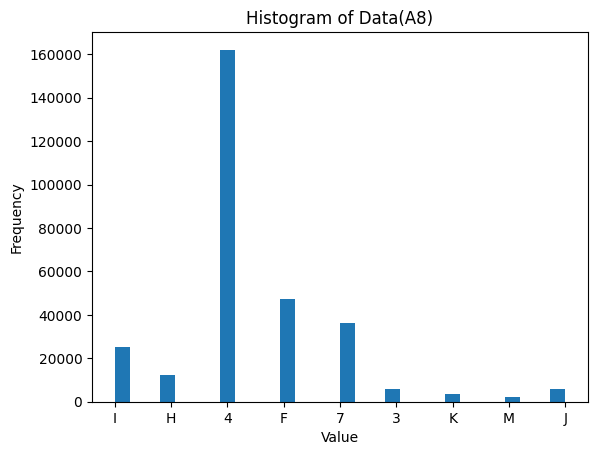

In [85]:
# 目的変数の可視化
plt.hist(df['A8'], bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data(A8)")
plt.show()

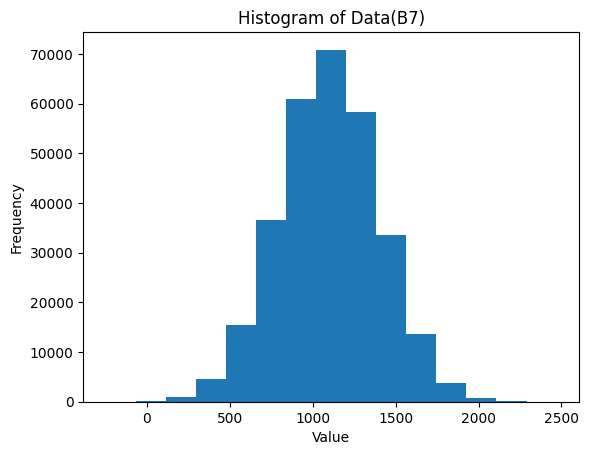

In [86]:
# 説明変数の可視化
plt.hist(df['E1'], bins=15)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data(B7)")
plt.show()

# 目的変数の加工

In [87]:
# キャッシュレス納付の「7,F,I,J,M」を「1」,それ以外を「0」にする
df['A8_1'] = df['A8'].apply(lambda x: 1 if x in ['7', 'F', 'I', 'J', 'M'] else 0)

In [88]:
# 割合の確認
a = df[df['A8_1']==1]
b = df[df['A8_1']==0]
print('キャッシュレス納付の割合:',len(a)/len(df))
print('窓口納付の割合:',len(b)/len(df))

キャッシュレス納付の割合: 0.38955
窓口納付の割合: 0.61045


# 説明変数の加工

In [89]:
# 利用勧奨ありの「1,2,3,4,5,6,9」を「1」,それ以外を「0」にする
df['B7_1'] = df['B7'].apply(lambda x: 1 if x in ['1', '2', '3', '4', '5', '6', '9'] else 0)

In [90]:
df_1 = df[df['B7_1']==1]
print('利用勧奨ありの件数:',len(df_1))

利用勧奨ありの件数: 1434


# データ型の設定

## データ定義書のデータ型に、作成したデータフレームのデータ型を合わせる

In [91]:
# データ型を調整
df['A5'] = df['A5'].astype(str)
df['A6'] = pd.to_datetime(df['A6'])
df['A7'] = df['A7'].astype(str)
df['B8'] = pd.to_datetime(df['B8'])
df['C3'] = pd.to_datetime(df['C3'])
df['E1'] = df['E1'].astype(str)
df['E3'] = pd.to_datetime(df['E3'])
df['Z6'] = pd.to_numeric(df['Z6'], errors='coerce')
df['B7_1'] = df['B7_1'].astype(str)
df['A8_1'] = df['A8_1'].astype(str)

# カテゴリ数の分割

## E1については、実際のデータを意識しカテゴリ数を2,100個としたが、one-hot Encodingができないなどの問題があるため、12個にカテゴリ数を削減する

In [92]:
# E1をカテゴリに分割する

# _df = df.copy()
df['E1'] =  df['E1'].astype(int)
conditions = [
    df['E1'] <= 100,
    (df['E1'] > 100) & (df['E1'] <= 300),
    (df['E1'] > 300) & (df['E1'] <= 500),
    (df['E1'] > 500) & (df['E1'] <= 700),
    (df['E1'] > 700) & (df['E1'] <= 800),
    (df['E1'] > 800) & (df['E1'] <= 900),
    (df['E1'] > 900) & (df['E1'] <= 1000),
    (df['E1'] > 1000) & (df['E1'] <= 1100),
    (df['E1'] > 1100) & (df['E1'] <= 1200),
    (df['E1'] > 1200) & (df['E1'] <= 1300),
    (df['E1'] > 1300) & (df['E1'] <= 1400),
     df['E1'] >= 1401
]

choices = [
    'A',
    'B',
    'C',
    'D',
    'E',
    'F',
    'G',
    'H',
    'I',
    'J',
    'K',
    'L'
]

# np.select を使用してカテゴリを作成
df['E1_1'] = np.select(conditions, choices, default='Unknown')

# カテゴリごとの件数を確認
print(df['E1_1'].value_counts().sort_index())

E1_1
A      131
B      975
C     5651
D    20734
E    20458
F    28150
G    35031
H    39059
I    39135
J    34847
K    28280
L    47549
Name: count, dtype: int64


# 交絡変数から処置変数への割り付け

## 実務では、交絡変数から予測モデルを作成し、処置変数を作成しているため、その状況を再現する

In [93]:
# 説明変数の選択
confounders = df[['E1_1', 'E2', 'I3', 'Z6', 'F1', 'G9', 'Z14']]  # 説明変数

# 空欄を0に置換
# confounders = confounders.replace({'E2': {'': '0'}, 'F1': {'':'0'}, 'I3': {'':'0'}, 'Z6': {'':'0'}}) # 複数の値を置換

# 名義尺度をダミー変数に変更
# 説明変数とする列のリスト
categorical_cols = ['E2', 'F1', 'I3', 'G9', 'E1_1']
_confounders = df[categorical_cols].copy() # 元のDataFrameを直接変更しないようにコピー
# OneHotEncoderを初期化
encoder = OneHotEncoder(sparse_output=False, drop='first')
# 指定した列をOne-Hotエンコーディング
encoded_cols = encoder.fit_transform(_confounders[categorical_cols])
# エンコードされた列の名前を取得
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
# エンコードされたデータを新しいデータフレームに変換
encoded_df = pd.DataFrame(encoded_cols, index=_confounders.index, columns=encoded_feature_names)
# 元のデータフレームからカテゴリカルな列を削除し、エンコードされたデータフレームと結合
confounders_processed = pd.concat([_confounders.drop(columns=categorical_cols), encoded_df], axis=1)

# 順序尺度を連続変数に変更
ordinal_scale = df[['Z6', 'Z14']]
ordinal_scale['Z6'] = pd.to_numeric(df['Z6'], errors='coerce')
ordinal_scale['Z14'] = pd.to_numeric(df['Z14'], errors='coerce')

# 日付型を連続変数に変換
# datetime_cols = _df[['E3']]
# datetime_cols['year'] = pd.to_datetime(datetime_cols['E3']).dt.year
# datetime_cols['month'] = pd.to_datetime(datetime_cols['E3']).dt.month

confounders = pd.concat([confounders_processed, ordinal_scale], axis=1) # datetime_cols[['year', 'month']]

# 欠損値の補完
confounders.fillna(0, inplace=True)

# B7_1 の生成
X = confounders.values
dummy_y = np.random.randint(0, 2, size=len(df))
model = LogisticRegression()
model.fit(X, dummy_y)
score = model.predict_proba(X)[:, 1]
threshold = np.quantile(score, 0.995)
df['B7_1'] = (score >= threshold).astype(int)

<ipython-input-93-34ff24ebe778>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_scale['Z6'] = pd.to_numeric(df['Z6'], errors='coerce')
<ipython-input-93-34ff24ebe778>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_scale['Z14'] = pd.to_numeric(df['Z14'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

# 交絡変数・処置変数から目的変数への因果効果の割り付け

In [94]:
# 3. A8_1_adjusted の生成（B7_1=1の人に5%効果上乗せ）
baseline_prob = 0.39
target_ate = 0.05

def generate_adjusted(row):
    prob = baseline_prob + target_ate if row['B7_1'] == 1 else baseline_prob
    return np.random.binomial(1, min(prob, 1.0))

df['A8_1_adjusted'] = df.apply(generate_adjusted, axis=1)
# 結果の確認
print(pd.crosstab(df['B7_1'], df['A8_1_adjusted'], normalize='index'))

A8_1_adjusted         0         1
B7_1                             
0              0.609896  0.390104
1              0.554667  0.445333


In [95]:
df = pd.concat([df,confounders[['E2_1', 'E2_2', 'F1_1', 'I3_1', 'I3_2', 'I3_3', 'I3_4', 'I3_5', 'I3_6',
       'I3_7', 'I3_8', 'I3_9', 'G9_0', 'G9_1', 'E1_1_B', 'E1_1_C', 'E1_1_D',
       'E1_1_E', 'E1_1_F', 'E1_1_G', 'E1_1_H', 'E1_1_I', 'E1_1_J', 'E1_1_K',
       'E1_1_L']]], axis=1)

# データの出力

In [ ]:
# データの出力
df.to_pickle('df_sample1_processed.pickle')

## 各パスの係数の大きさは任意に設定する

In [ ]:
# df_pass = pd.concat([confounders, df['B7_1']], axis=1)

In [ ]:
# A8_1_adjusted を生成：交絡因子と B7_1 の両方から生成
# 各変数に適当な重みを割り当て（ここは任意・調整可）
# from scipy.special import expit  # シグモイド関数（ロジスティック）

# ダミー重み（E1_1 はカテゴリなので get_dummies 後の列に対応）
# weights = {
#     'Z6': 0.01,
#     'Z14': 0.017,
#     'B7_1': 0.013,
#     # E1 がエンコードされていれば、その列名と重みを追加
#     **{col: np.random.rand() * 0.005 - 0.005 for col in df_pass.columns if col.startswith('E1_')},
#     **{col: np.random.rand() * 0.005 - 0.005 for col in df_pass.columns if col.startswith('E2_')},
#     **{col: np.random.rand() * 0.005 - 0.005 for col in df_pass.columns if col.startswith('F1_')},
#     **{col: np.random.rand() * 0.005 - 0.005 for col in df_pass.columns if col.startswith('G9_')},
#     **{col: np.random.rand() * 0.005 - 0.005 for col in df_pass.columns if col.startswith('I3_')}
# }

# ベース確率
# intercept = -1.5  # だいたい0.39くらいになるように調整

# def compute_prob(row):
#     logit = intercept
#     for var, coef in weights.items():
#         if var in row.index:  # 列が存在するか確認
#             logit += coef * row[var]
#         else:
#             print(f"警告: 重み '{var}' に対応する列が DataFrame に存在しません。")
#     return expit(logit)  # 確率に変換

# A8_1_adjustedを生成（確率的に1 or 0）
# if 'A8_1_adjusted_prob' not in df_pass.columns:
#     df_pass['A8_1_adjusted_prob'] = df_pass.apply(compute_prob, axis=1)
# if 'A8_1_adjusted' not in df_pass.columns:
#     df_pass['A8_1_adjusted'] = df_pass['A8_1_adjusted_prob'].apply(lambda p: np.random.binomial(1, p))

In [ ]:
# B7_1の係数バランス
# avg_abs_other = np.mean([abs(c) for k, c in weights.items() if k != 'B7_1'])
# print(f"B7_1 の係数: {weights['B7_1']:.4f}")
# print(f"他変数の平均係数: {avg_abs_other:.4f}")
# print(f"倍率: {weights['B7_1'] / avg_abs_other:.2f}倍")

# 結果の確認
# print(pd.crosstab(df_pass['B7_1'], df_pass['A8_1_adjusted'], normalize='index'))